# Uso de filtros espaciales y morfológicos

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_unir_color = cv.imread('im/unir-1.jpg')
image_unir_grays = cv.imread('im/unir-1.jpg', cv.IMREAD_GRAYSCALE)

In [3]:
# Imagen en binario
thresh = 128 #La mitad de bits
image_unir_bin = cv.threshold(image_unir_grays, thresh, 255, cv.THRESH_BINARY)[1]

In [4]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.uint8)
    return mask

kernel_3 = mask(3)
kernel_5 = mask(5)
kernel_7 = mask(7)

kernel = kernel_3

im = image_unir_grays

erosion = cv.erode(im, kernel, iterations=1)
dilation = cv.dilate(im, kernel, iterations=1)
cv.imwrite('out/erosion.jpg', erosion)
cv.imwrite('out/dilation.jpg', dilation)

In [5]:
def padding(originalImg, padSize):
    padImg = np.zeros((rows+2*padSize, columns+2*padSize), dtype=np.uint8)
    # recortando
    padImg[padSize:rows+padSize, padSize:columns+padSize] = originalImg
    return padImg
def Erosion(padImg, kernel, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            # se suma el elemento estructural y la ventana
            portion1 = portion.flatten()
            portion2 = kernel.flatten()
            p1 = (np.sum(portion1))
            p2 = (np.sum(portion2))*255
            # la condicional para que no revase el limite
            if p1 == p2:
                output[i, j] = 255
            else:
                output[i, j] = np.min(portion1)
    return output
def Dilatacion(padImg, size):
    output = np.zeros((rows, columns), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, columns):
            # recortando
            portion = padImg[i:i+size, j:j+size]
            portion1 = portion.flatten()
            # la condicional para que no revase el limite
            if 255 in portion1:
                output[i, j] = 255
            else:
                output[i, j] = np.max(portion1)
    return output

In [6]:
# Esta es la dimensión del kernel original
size = 9
# Tamaño del padding
p_size = size // 2
im = image_unir_grays
# se obtiene los tamaños de la imagen
rows = im.shape[0]
columns = im.shape[1]
# se obtiene el padding inicial
padImg = padding(im, p_size)

In [7]:
#aplicamos dilatacion
dilation = Dilatacion(padImg, size)
cv.imwrite('out/dilation.jpg', dilation)
#aplicamos erosion
erosion = Erosion(padImg, kernel, size)
cv.imwrite('out/erosion.jpg',erosion)

True

In [8]:
border_d_e = cv.subtract(dilation, erosion)
border_i_e = cv.subtract(im, erosion)
border_res = dilation - erosion
cv.imwrite('out/border_d_e.jpg', border_d_e)
cv.imwrite('out/border_i_e.jpg', border_i_e)
cv.imwrite('out/border_res.jpg', border_res)

True

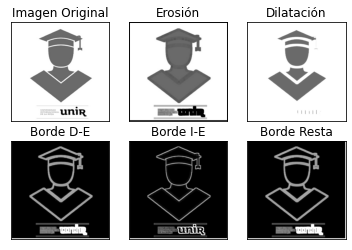

In [9]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
erosion = cv.cvtColor(erosion, cv.COLOR_BGR2RGB)
dilation = cv.cvtColor(dilation, cv.COLOR_BGR2RGB)
border_d_e = cv.cvtColor(border_d_e, cv.COLOR_BGR2RGB)
border_i_e = cv.cvtColor(border_i_e, cv.COLOR_BGR2RGB)
border_res = cv.cvtColor(border_res, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(erosion)
plt.title('Erosión'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(dilation)
plt.title('Dilatación'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(border_d_e)
plt.title('Borde D-E'), plt.xticks([]), plt.yticks([])
plt.subplot(235)
plt.imshow(border_i_e)
plt.title('Borde I-E'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(border_res)
plt.title('Borde Resta'), plt.xticks([]), plt.yticks([])
plt.show()

Me parece que las funciones erode y dilation las tengo al revés, es decir, trabaja sobre el fondo y no sobre el color. Luego revisaré los apuntes

[Enlace de referencia](https://www.educba.com/opencv-erode/)

# Canny

In [10]:
# Los números son las intensidades min y máx para identificar el borde
im = image_unir_grays
canny = cv.Canny(im, 25, 150)
cv.imwrite('out/canny.jpg', canny)

True

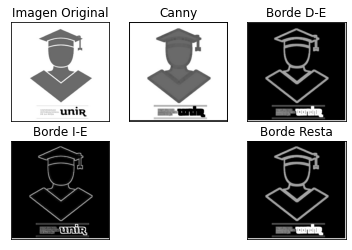

In [11]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
plt.subplot(231)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232)
plt.imshow(erosion)
plt.title('Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(233)
plt.imshow(border_d_e)
plt.title('Borde D-E'), plt.xticks([]), plt.yticks([])
plt.subplot(234)
plt.imshow(border_i_e)
plt.title('Borde I-E'), plt.xticks([]), plt.yticks([])
plt.subplot(236)
plt.imshow(border_res)
plt.title('Borde Resta'), plt.xticks([]), plt.yticks([])
plt.show()